In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data',train=True,download=True,transform=transforms)
test_dataset = datasets.MNIST('./data',train=False,download=True,transform=transforms)

In [4]:
train_iterator = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=128)

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_hidden_layer1= nn.Linear(in_features=784, out_features=128)
        self.encoder_hidden_layer2= nn.Linear(in_features=128, out_features=64)
        self.mu = nn.Linear(in_features=64, out_features=10)
        self.var = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        hidden1 = F.relu(self.encoder_hidden_layer1(x))
        hidden2 = F.relu(self.encoder_hidden_layer2(hidden1))
        z_mu = self.mu(hidden2)
        z_var = self.var(hidden2)
        return z_mu, z_var

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder_hidden_layer1= nn.Linear(in_features=10, out_features=64)
        self.decoder_hidden_layer2= nn.Linear(in_features=64, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=784)

    def forward(self, x):
        hidden1 = F.relu(self.decoder_hidden_layer1(x))
        hidden2 = F.relu(self.decoder_hidden_layer2(hidden1))
        predicted = torch.sigmoid(self.out(hidden2))
        return predicted


In [7]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        #encode
        z_mu, z_var = self.enc(x)
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var


In [8]:
encoder = Encoder()
decoder = Decoder()
model = VAE(encoder, decoder).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
def train():
    model.train()
    train_loss = 0
    for i, (x, _) in enumerate(train_iterator):
        x = x.view(-1, 28 * 28)
        x = x.to(device)
        optimizer.zero_grad()
        x_sample, z_mu, z_var = model(x)
        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)
        # kl divergence loss
        kl_loss = 0.001 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)
        # total loss
        loss = recon_loss + kl_loss       # backward pass
        loss.backward()
        train_loss += loss.item()
        # update the weights
        optimizer.step()

    return train_loss

In [10]:
def test():
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            x = x.view(-1, 28 * 28)
            x = x.to(device)
            x_sample, z_mu, z_var = model(x)
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)         
            kl_loss = 0.001 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var) 
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss


In [11]:
best_test_loss = float('inf')
N_EPOCHS = 50
Loss=[]
for e in range(N_EPOCHS):
    train_loss = train()
    test_loss = test()

    train_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    Loss.append(train_loss)
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

C:\Users\supri\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 281.23, Test Loss: 206.77
Epoch 1, Train Loss: 198.74, Test Loss: 190.37
Epoch 2, Train Loss: 186.76, Test Loss: 180.02
Epoch 3, Train Loss: 172.31, Test Loss: 165.77
Epoch 4, Train Loss: 159.02, Test Loss: 150.22
Epoch 5, Train Loss: 146.23, Test Loss: 141.34
Epoch 6, Train Loss: 139.34, Test Loss: 135.12
Epoch 7, Train Loss: 133.84, Test Loss: 130.22
Epoch 8, Train Loss: 129.08, Test Loss: 125.51
Epoch 9, Train Loss: 124.88, Test Loss: 122.01
Epoch 10, Train Loss: 121.77, Test Loss: 119.18
Epoch 11, Train Loss: 119.20, Test Loss: 116.78
Epoch 12, Train Loss: 116.97, Test Loss: 114.71
Epoch 13, Train Loss: 114.83, Test Loss: 112.52
Epoch 14, Train Loss: 112.69, Test Loss: 110.57
Epoch 15, Train Loss: 110.91, Test Loss: 108.99
Epoch 16, Train Loss: 109.50, Test Loss: 107.74
Epoch 17, Train Loss: 108.35, Test Loss: 106.65
Epoch 18, Train Loss: 107.39, Test Loss: 105.73
Epoch 19, Train Loss: 106.54, Test Loss: 104.99
Epoch 20, Train Loss: 105.76, Test Loss: 104.24
Ep

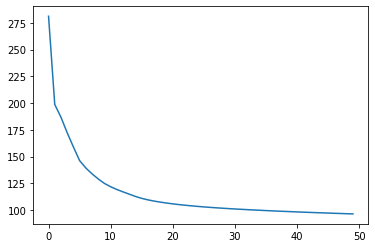

In [12]:
plt.plot(Loss)
plt.show()

# Reconstuction of Image

In [13]:
def show_torch_image(torch_tensor):
    plt.imshow(torch_tensor.numpy().reshape(28, 28), cmap='gray')
    plt.show()

In [45]:
model.eval()
predictions = []

with torch.no_grad():
    for i, (batch_features, _) in enumerate(test_iterator):
        batch_features = batch_features.view(-1, 784).to(device)
        x_sample1, z_mu1, z_var1 = model(batch_features)  
        for prediction in x_sample1:
            predictions.append(prediction)
  


       
len(predictions)   

10000

In [46]:
predictions[0].shape

torch.Size([784])

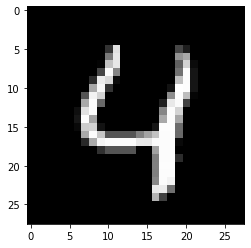

In [47]:
# Real Image
show_torch_image(test_dataset[4][0])

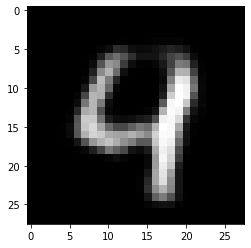

In [49]:
# generated image
show_torch_image(predictions[4])

# generation of new image

torch.Size([1, 10])
torch.Size([28, 28])


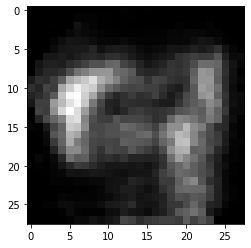

In [50]:
# sample and generate a image
z = torch.randn(1, 10).to(device)

# run only the decoder
reconstructed_img = model.dec(z)
img = reconstructed_img.view(28, 28).data

print(z.shape)
print(img.shape)

plt.imshow(img, cmap='gray')